In [1]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from kymatio import Scattering2D
from phase_scattering2d_torch import ScatteringTorch2D_wph
from models.ISTC import ISTC, relu
from models.Rescaling import Rescaling
from models.LinearProj import LinearProj
from models.Classifier import Classifier
from models.SparseScatNet import SparseScatNet

from torch.utils.tensorboard import SummaryWriter
from utils import print_and_write, compute_stding_matrix

import math
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [2]:
mpl.rcParams["figure.figsize"] = (16,9)
mpl.rcParams["axes.titlesize"] = 15

Create a folder to save all the plots

In [3]:
if not os.path.exists('plots'):
    os.makedirs('plots')

# Load the saved model

In [4]:
! ls 

LICENSE
README.md
__pycache__
checkpoints
checkpoints_sparsescatnet
checkpoints_sparsescatnet_100_class
checkpoints_sparsescatnet_100_class_dict_save
checkpoints_sparsescatnet_10_class
checkpoints_sparsescatnet_16
checkpoints_sparsescatnet_30_class
cmd.txt
convergence_analysis.ipynb
convergence_analysis.py
main.py
model_analysis.ipynb
models
phase_scattering2d_torch.py
plots
run_from_cluster.ipynb
sparsescatnet_logs
sparsescatnet_logs_100_class
sparsescatnet_logs_100_class_dict_save
sparsescatnet_logs_10_class
sparsescatnet_logs_16
sparsescatnet_logs_30_class
standardization
training_logs
utils.py
utils_sampling


In [5]:
! ls sparsescatnet_logs_100_class

classes_indices_selected
events.out.tfevents.1614865438.sh15.2266.0
events.out.tfevents.1614865650.sh15.2634.0
events.out.tfevents.1614865864.sh15.2942.0
events.out.tfevents.1614941404.sh15.24593.0
events.out.tfevents.1615398692.sh04.29827.0
summary_file.txt
training_sparsescatnet_b_256_lrfreq_60.log


In [6]:
! ls checkpoints_sparsescatnet_100_class/

sparsescatnet_batchsize_256_lrfreq_60.pth.tar
sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar


In [7]:
model_path = "checkpoints_sparsescatnet_100_class/sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar"

We will analyse the saved model with image size equals to 100 and for which we used 100 classes for the training

In [8]:
loaded_dict = torch.load(model_path)

In [9]:
loaded_dict.keys()

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc1', 'optimizer'])

In [10]:
loaded_dict["optimizer"].keys()

dict_keys(['state', 'param_groups'])

In [11]:
best_epoch = loaded_dict["epoch"]

In [12]:
loaded_dict["state_dict"].keys()

odict_keys(['module.scattering.0.tensor0', 'module.scattering.0.tensor1', 'module.scattering.0.tensor2', 'module.scattering.0.tensor3', 'module.scattering.0.tensor4', 'module.scattering.0.tensor5', 'module.scattering.0.tensor6', 'module.scattering.0.tensor7', 'module.scattering.0.tensor8', 'module.scattering.0.tensor9', 'module.scattering.0.tensor10', 'module.scattering.0.tensor11', 'module.scattering.0.tensor12', 'module.scattering.0.tensor13', 'module.scattering.0.tensor14', 'module.scattering.0.tensor15', 'module.scattering.0.tensor16', 'module.scattering.0.tensor17', 'module.scattering.0.tensor18', 'module.scattering.0.tensor19', 'module.scattering.0.tensor20', 'module.scattering.0.tensor21', 'module.scattering.0.tensor22', 'module.scattering.0.tensor23', 'module.scattering.0.tensor24', 'module.scattering.0.tensor25', 'module.scattering.0.tensor26', 'module.scattering.0.tensor27', 'module.scattering.0.tensor28', 'module.scattering.0.tensor29', 'module.scattering.0.tensor30', 'modul

# Use the args used to train the model 

In [13]:
model_names = ['sparsescatnet', 'sparsescatnetw', 'scatnet']

NEW_IMAGE_SIZE = 100

arch               = "sparsescatnet"
scattering_J       = 4
scattering_order2  = True
scat_angles        = 8
scattering_wph     = True
scattering_nphases = 4
nb_classes         = 100
L_proj_size        = 256
L_kernel_size      = 3
n_iterations       = 12
dictionary_size    = 2048
classifier_type    = "mlp"
lambda_0           = 0.3
lambda_star        = 0.05
lambda_star_lb     = 0.05
grad_lambda_star   = True
epsilon_lambda_0   = 1
output_rec         = False
nb_hidden_units    = 4096
nb_l_mlp           = 2
dropout_p_mlp      = 0.3
avg_ker_size       = 3
BS                 = 256
workers            = 10

## Model creation

In [14]:
if arch in model_names:
    n_space = NEW_IMAGE_SIZE
    nb_channels_in = 3

    # create scattering
    J = scattering_J
    L_ang = scat_angles

    max_order = 2 if scattering_order2 else 1

    if scattering_wph:
        A = scattering_nphases
        scattering = ScatteringTorch2D_wph(J=J, shape=(NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), L=L_ang, A=A, 
                                           max_order=max_order)                                    
    else:
        scattering = Scattering2D(J=J, shape=(NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), L=L_ang, 
                                  max_order=max_order)
    # Flatten scattering
    scattering = nn.Sequential(scattering, nn.Flatten(1, 2))

    if scattering_wph:
        nb_channels_in += 3 * A * L_ang * J
    else:
        nb_channels_in += 3 * L_ang * J

    if max_order == 2:
        nb_channels_in += 3 * (L_ang ** 2) * J * (J - 1) // 2

    n_space = n_space // (2 ** J)
###########################################################################################
    
    std_file = 'standardization/ImageNet2012_scattering_J{}_order{}_wph_{}_nphases_{}_nb_classes_{}.pth.tar'.format(
        scattering_J, 2 if scattering_order2 else 1, scattering_wph,
        scattering_nphases if scattering_wph else 0, nb_classes)

    # compute the mean and the std of the data
    if os.path.isfile(std_file):
        std_dict = torch.load(std_file)
        mean_std = std_dict['mean']
        stding_mat = std_dict['matrix']
    else:
        print("standirisation file not found")

    standardization = Rescaling(mean_std, stding_mat)
    
    if arch in ['sparsescatnet', 'sparsescatnetw']:
        proj = nn.Conv2d(nb_channels_in, L_proj_size, kernel_size=L_kernel_size, stride=1,
                         padding=0, bias=False)
        nb_channels_in = L_proj_size
        linear_proj = LinearProj(standardization, proj, L_kernel_size)
    else:  # scatnet
        proj = nn.Identity()
        linear_proj = LinearProj(standardization, proj, 0)

    ###########################################################################################

    # Create ISTC (when applicable)
    if arch in ['sparsescatnet', 'sparsescatnetw']:
    ###########################################################################################
        if arch == 'sparsescatnet':
            istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                        lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                        grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                        output_rec=output_rec)

        elif arch == 'sparsescatnetw':
            istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                        lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                        grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                        output_rec=output_rec, use_W=True)

        if not output_rec:
            nb_channels_in = dictionary_size

    elif arch == 'scatnet':
        print("=> creating model ScatNet with phase scattering {} and classifier {}".\
            format(scattering_wph, classifier_type))

    # Create classifier
    ###########################################################################################
    classifier = Classifier(n_space, nb_channels_in, classifier_type=classifier_type,
                            nb_classes=1000, nb_hidden_units=nb_hidden_units, nb_l_mlp=nb_l_mlp,
                            dropout_p_mlp=dropout_p_mlp, avg_ker_size=avg_ker_size)

    # Create model
    ###########################################################################################
    #model = SparseScatNet(scattering, linear_proj, istc, nn.Identity(), return_full_inf=False)
    if arch in ['sparsescatnet', 'sparsescatnetw']:
        model = SparseScatNet(scattering, linear_proj, istc, classifier, return_full_inf=True)  # print model info

    elif arch == 'scatnet':
        model = nn.Sequential(scattering, linear_proj, classifier)
else:
    print("not a valid model")

## Update the model using the saved weights 

In [15]:
model_dict = model.state_dict()
checkpoint_dict = loaded_dict['state_dict']
checkpoint_dict = {k: v for k, v in checkpoint_dict.items() if k in model_dict}
model_dict.update(checkpoint_dict)
model.load_state_dict(model_dict)
dictionary = model.istc.dictionary_weight.data
w_matrix   = model.istc.w_weight.data

model to GPU and enable eval mode

In [16]:
model.cuda()
model.eval()

SparseScatNet(
  (scattering): Sequential(
    (0): ScatteringTorch2D_wph()
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (linear_proj): LinearProj(
    (standardization): Rescaling()
    (proj): Conv2d(1539, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (istc): ISTC()
  (classifier): Classifier(
    (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (classifier): Sequential(
      (0): Linear(in_features=32768, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=4096, out_features=4096, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
  )
)

## Load data 

We chose to use the validation set

In [17]:
path_data = "~/Datasets/ImageNet/ILSVRC/Data/CLS-LOC"

valdir   = os.path.join(path_data, 'val')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

dataset = datasets.ImageFolder(valdir, transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.Resize((NEW_IMAGE_SIZE, NEW_IMAGE_SIZE)),
                    transforms.ToTensor(),
                    normalize,
                ]))

Only a subset of the dataset will be analysed

In [18]:
dataset = torch.utils.data.Subset(dataset, range(100))

In [19]:
loader  = torch.utils.data.DataLoader(dataset, batch_size=BS, shuffle=False, 
                                      num_workers=workers, pin_memory=True)

have the loader as a iterable list

In [20]:
iter_loader = next(iter(loader))[0]

## Let's have a look at the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


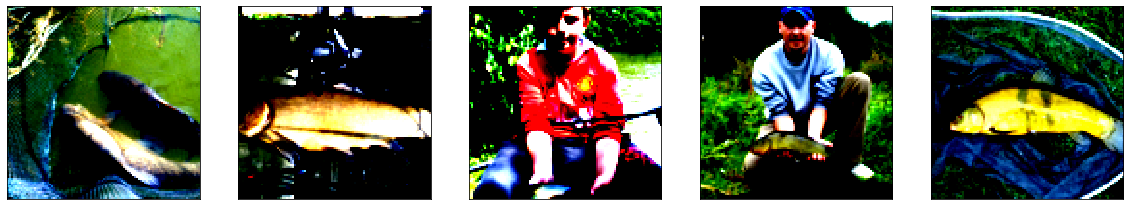

In [21]:
nsamples = 5
imgs, labels = next(iter(loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(torch.transpose(torch.transpose(imgs[i, :, :, :], 0, 2), 0, 1), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

title_plot = "examples_ImageNet"
plt.savefig(f"plots/{title_plot}.png")
plt.show()

## 

In [22]:
n_examples = 10
input_test = iter_loader[0:n_examples].cuda()

### Scattering:

In [23]:
model.scattering

Sequential(
  (0): ScatteringTorch2D_wph()
  (1): Flatten(start_dim=1, end_dim=2)
)

In the case of 2D inputs data, and for an input tensor $(B,C,N_1,N_2)$, with $J = $scattering_J and $L = $scat_angles and $A = $scattering_nphases, the output tensor has the following dimension :



if scattering_order2 == False : 
$$ (B, C, 1 + LJ + \frac{L^{2}J(J-1)}{2}, \frac{N_1}{2^J}, \frac{N_2}{2^J})  $$

if scattering_order2 == True : 
$$ (B, C, 1 + ALJ + \frac{L^{2}J(J-1)}{2}, \frac{N_1}{2^J}, \frac{N_2}{2^J})  $$

In [24]:
print("-----------------------------")
print("variables values : ")
print(f"scattering_order2      = {scattering_order2}")
print(f"scattering_J       (J) = {scattering_J}")
print(f"scat_angles        (L) = {scat_angles}")
print(f"scattering_nphases (A) = {scattering_nphases}")
print("-----------------------------")
print(f"dimension of the inputs  : (B, {input_test[0].size()[0]}, {input_test[0].size()[1]}, {input_test[0].size()[2]})")
print()
dim_3 = 1 + 0.5*scattering_J*(scattering_J-1)*scat_angles**2
if scattering_order2 : 
    dim_3 += scattering_nphases*scat_angles*scattering_J
else : 
    dim_3 += scat_angles*scattering_J
dim_3 = int(dim_3)
print(f"dimension of the outputs (expected) : (B, {input_test[0].size()[0]}, {dim_3}, {input_test[0].size()[1]//2**scattering_J}, {input_test[0].size()[2]//2**scattering_J})")
print("-----------------------------")

-----------------------------
variables values : 
scattering_order2      = True
scattering_J       (J) = 4
scat_angles        (L) = 8
scattering_nphases (A) = 4
-----------------------------
dimension of the inputs  : (B, 3, 100, 100)

dimension of the outputs (expected) : (B, 3, 513, 6, 6)
-----------------------------


In [25]:
model.scattering[0](input_test).shape

/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scattering2d/backend/torch_backend.py:231: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  output = torch.fft(x, 2, normalized=False)
/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scattering2d/backend/torch_backend.py:226: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  output = torch.irfft(x, 2, normalized=False, onesided=False)
/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scatteri

torch.Size([10, 3, 513, 6, 6])

## Visualisation of the scattering transform on the images

In [26]:
def draw_scattering_coef(img_array, scat_coef, J, L, A, save = False, path = "img.png") :
    
    fig, ax = plt.subplots(figsize=(7,7)) 
    
    ## plot the image 
    ax.imshow(img_array, vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    ## plot the scattering coefficients
    norm = mpl.colors.Normalize(scat_coef.min(), scat_coef.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap="magma")  ## gray
    nb_coeffs, window_rows, window_columns = scat_coef.shape
    
    
    ax.axis('off')
    offset = 0.1
    for row in range(window_rows):
        for column in range(window_columns):
            ax=fig.add_subplot(window_rows, window_columns, 1 + column + row * window_rows, projection='polar')
            ax.set_ylim(0, 1)
            ax.axis('off')
            ax.set_yticklabels([])  # turn off radial tick labels (yticks)
            ax.set_xticklabels([])  # turn off degrees
            # ax.set_theta_zero_location('N')  # 0° to North
            coefficients = scat_coef[:, row, column]
            for j in range(J):
                for l in range(L):
                    coeff = coefficients[l + (J - 1 - j) * L]
                    color = mpl.colors.to_hex(mapper.to_rgba(coeff))
                    ax.bar(x=(4.5+l) *  np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
                    ax.bar(x=(4.5+l+L) * np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
    if save : 
        plt.savefig(path)
    plt.show()

In [27]:
scattering_coefficients = model.scattering[0](input_test).cpu().numpy()

## invert colors : 
scattering_coefficients = -scattering_coefficients

In [28]:
## skip the low pass filter 
scattering_coefficients = scattering_coefficients[:,:,1:,:,:]

In [29]:
scattering_coefficients.shape

(10, 3, 512, 6, 6)

 -- NOTE : since the images are in RGB (3 axis), the scattering rings plotted are the mean of the 3 axis !


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


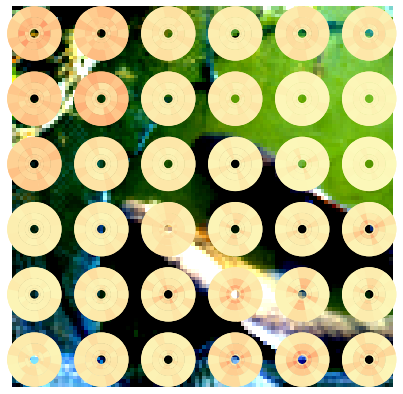

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


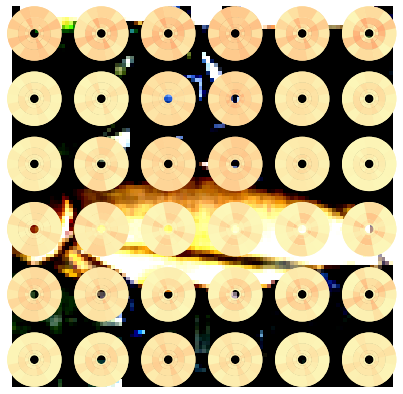

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


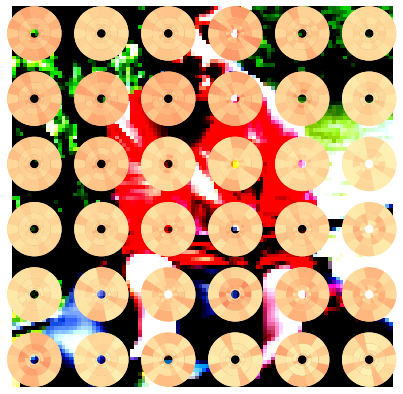

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


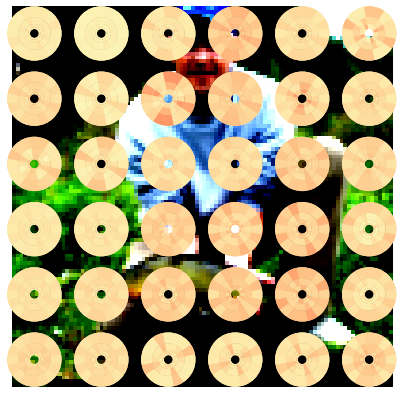

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


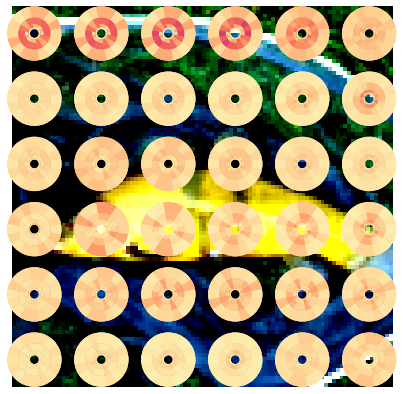

In [30]:
print(" -- NOTE : since the images are in RGB (3 axis), the scattering rings plotted are the mean of the 3 axis !")

imgs, labels = next(iter(loader))

nsamples = 5

for i in range(nsamples):
    title_plot = f"plots/scattering_output_{i}.png"
    draw_scattering_coef(torch.transpose(torch.transpose(imgs[i, :, :, :], 0, 2), 0, 1),
                         scattering_coefficients[i].mean(axis=0), scattering_J, scat_angles, 
                         scattering_nphases, save=True, path=title_plot)

In [31]:
out_scat = model.scattering(input_test.cuda())

In [32]:
print(f"flatten is applied to the output of the scattering, thus we will have a tensor of size: (\
{n_examples}, {3*dim_3}, \
{input_test[0].size()[1]//2**scattering_J}, {input_test[0].size()[2]//2**scattering_J})"\
     )

out_scat.size()

flatten is applied to the output of the scattering, thus we will have a tensor of size: (10, 1539, 6, 6)


torch.Size([10, 1539, 6, 6])

### Linear Projection:

In [33]:
model.linear_proj

LinearProj(
  (standardization): Rescaling()
  (proj): Conv2d(1539, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
)

In [34]:
scat_stand = model.linear_proj.standardization(out_scat)

In [35]:
scat_stand.size()

torch.Size([10, 1539, 6, 6])

In [36]:
lin_out = model.linear_proj(out_scat)

* In this case, the linear projection is done using a conv2D layer 

In [37]:
lin_out.size()

torch.Size([10, 256, 6, 6])

In [38]:
linp_p = lin_out.view(-1,L_proj_size)[0,:].cpu().detach().numpy()

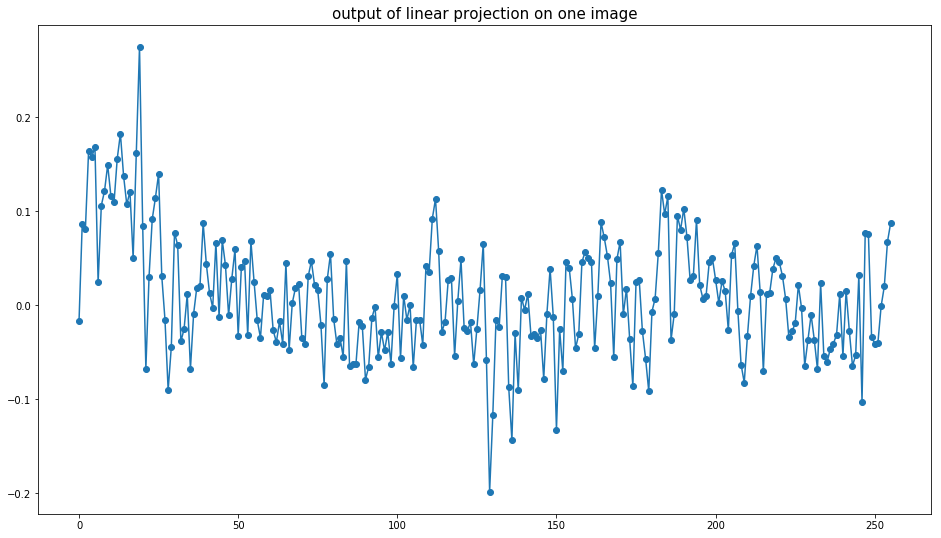

In [39]:
plt.figure(figsize=(16,9))
plt.plot(linp_p, "-o")
title_plot = "output of linear projection on one image"
plt.title(title_plot)
plt.savefig(f"plots/{title_plot}.png")
plt.show()

### ISTC:

In [40]:
model.istc

ISTC()

In [41]:
istc_out = model.istc(lin_out)

In [42]:
istc_out.size()

torch.Size([10, 2048, 6, 6])

In [43]:
model.istc.dictionary_weight.size(), lin_out.size()

(torch.Size([256, 2048, 1, 1]), torch.Size([10, 256, 6, 6]))

In [44]:
torch.matmul(lin_out.view(10,6,6,256), model.istc.dictionary_weight.view(256, 2048)).view(10,2048,6,6).norm(p=2)

tensor(53.8764, device='cuda:0', grad_fn=<NormBackward1>)

In [45]:
istc_out.norm(p=2), lin_out.norm(p=2)

(tensor(8.6067, device='cuda:0', grad_fn=<NormBackward1>),
 tensor(18.9737, device='cuda:0', grad_fn=<NormBackward1>))

In [46]:
istc_arr = istc_out.view(-1,dictionary_size)[0,:].cpu().detach().numpy()

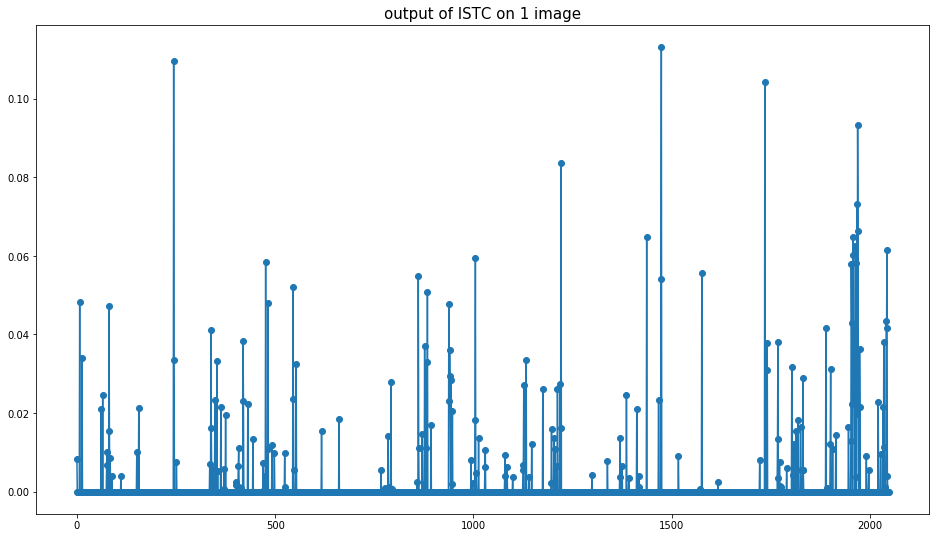

In [47]:
plt.figure(figsize=(16,9))
plt.plot(istc_arr, "-o")
title_plot = "output of ISTC on 1 image"
plt.title(title_plot)
plt.savefig(f"plots/{title_plot}.png")
plt.show()

### Classifier:

In [48]:
out_scat.shape[2]

6

In [49]:
model.classifier

Classifier(
  (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [50]:
n = out_scat.shape[2]  ### 6 for image size == 100
if avg_ker_size > 1:
    n += -avg_ker_size + 1

in_planes = nb_channels_in * (n ** 2)
print(f"The size of the first linear layer in mode.classifier.classifier is equal to {in_planes}")

The size of the first linear layer in mode.classifier.classifier is equal to 32768


In [51]:
clas_out = model.classifier(istc_out)

In [52]:
clas_out.size()

torch.Size([10, 1000])

## Apply the model to the input data (all layers)

In [53]:
output, _, sparsity, support_size, support_diff, rec_loss_rel = model(input_test)

In [54]:
output.size()

torch.Size([10, 1000])

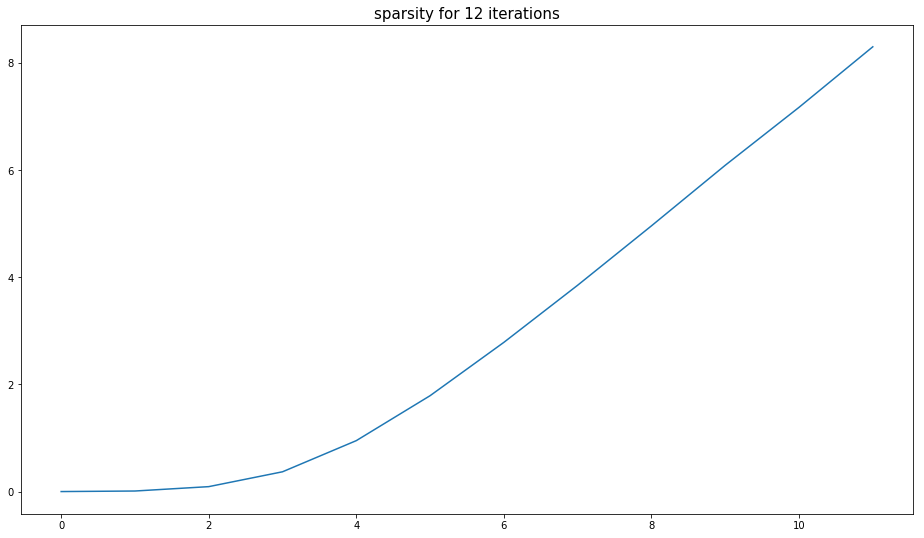

In [55]:
plt.figure()
plt.plot(sparsity.detach().cpu().numpy())
title_plot = f"sparsity for {n_iterations} iterations"
plt.title(title_plot)
plt.savefig(f"plots/{title_plot}.png")
plt.show()

## Functions to analyse the sparsity of the dictoinary

The followings 2 functions are from the git : j-zarka/SparseScatNet (edited)

In [56]:
def compute_sparse_code_FISTA(input_batch, dictionary, lambda_star, maxiter, tol=1e-3):
    with torch.no_grad():
        L = torch.symeig(torch.mm(dictionary[..., 0, 0].t(), dictionary[..., 0, 0]))[0][-1]
        input_size, dict_size = dictionary.size(0), dictionary.size(1)

        support_size_FISTA_curve = np.zeros(maxiter)

        batch_size, M, N = input_batch.size(0), input_batch.size(2), input_batch.size(3)
        x = input_batch.new_zeros(batch_size, dict_size, M, N)
        t = 1
        y = x.clone()
        dictionary = dictionary.cuda()
        for i_iter in range(maxiter):
            x_old = x.clone()
            D_y = nn.functional.conv2d(y, dictionary)
            y = y + nn.functional.conv2d(input_batch - D_y, dictionary.transpose(0, 1).contiguous()) / L
            x = relu(y, lambda_star / L)
            t0 = t
            t = (1. + math.sqrt(1. + 4. * t ** 2)) / 2.
            y = x + ((t0 - 1.) / t) * (x - x_old)

            support_size_FISTA_curve[i_iter] = (x != 0).sum().item()

            diff = ((x - x_old).norm(p=2, dim=1) / (x.norm(p=2, dim=1) + 1e-10))

            if tol is not None and diff.max() < tol:
                support_size_FISTA_curve[i_iter:] = support_size_FISTA_curve[i_iter - 1]
                break
    return x, support_size_FISTA_curve

In [57]:
def compute_conv_model(model, val_loader, dictionary, w_matrix, override_lambdas=None):
    with torch.no_grad():
        input_size, dict_size = dictionary.size(0), dictionary.size(1)
        
        dictionary = dictionary.cuda()
        w_matrix = w_matrix.cuda()

        if override_lambdas is not None:
            n_iterations = len(override_lambdas)
        else:
            n_iterations = model.istc.n_iterations

        loss_curve = np.zeros(n_iterations)
        conv = np.zeros(n_iterations)
        x_star_norm = np.zeros(1)
        support_size_x_star = np.zeros(n_iterations)
        support_size_x_star_curve = np.zeros(200)
        support_size_model = np.zeros(n_iterations)
        support_incl = np.zeros(n_iterations)
        support_diff = np.zeros(n_iterations)
        
        list_x_star =[]

        if override_lambdas is not None:
            lambdas = override_lambdas
        else:
            lambdas = torch.zeros(n_iterations)
            lambdas[-1] = model.istc.lambda_star
            for i in range(n_iterations-1):
                lambdas[i] = model.istc.lambdas[i]

        for _, (input_batch, target) in enumerate(val_loader):
            input_batch = input_batch.cuda()
            input_batch = model(input_batch, return_proj=True)
            batch_size, M, N = input_batch.size(0), input_batch.size(2), input_batch.size(3)
            # Use FISTA to compute the l1 problem solution
            x_star, support_size_x_star_batch = compute_sparse_code_FISTA(input_batch, dictionary, lambdas[-1],
                                                                          maxiter=200, tol=1e-3)
            list_x_star += [x_star[i:i+1] for i in range(x_star.size(0))]  ## save x_star
            
            x_star_norm += (x_star.norm(p=2) ** 2).sum().item()
            support_size_x_star_curve += support_size_x_star_batch

            support_size_x_star[:] += (x_star != 0).sum().item()

            x = input_batch.new_zeros(batch_size, dict_size, M, N)
            

            for i_iter in range(n_iterations):
                D_x = nn.functional.conv2d(x, dictionary)
                x = x + nn.functional.conv2d(input_batch - D_x, w_matrix.transpose(0, 1).contiguous())
                x = relu(x, lambdas[i_iter])

                rec_error = 0.5*((nn.functional.conv2d(x, dictionary) - input_batch).norm(p=2, dim=1) ** 2).sum().item()
                sparsity_loss = (lambdas[-1]*x).norm(p=1, dim=1).sum().item()
                loss_curve[i_iter] += rec_error + sparsity_loss
                conv[i_iter] += ((x - x_star).norm(p=2) ** 2).sum().item()
                support_size_model[i_iter] += (x != 0).sum()
                support_incl[i_iter] += (((x != 0) * (x_star != 0)).sum(dim=1) /
                                         torch.max(torch.ones(1).cuda(), (x_star != 0).sum(dim=1).type(torch.cuda.FloatTensor))).sum().item()
                support_diff[i_iter] += (((x != 0) * (x_star == 0)).sum(dim=1) /
                                         torch.max(torch.ones(1).cuda(), (x_star != 0).sum(dim=1).type(torch.cuda.FloatTensor))).sum().item()

        support_incl /= (M * N * len(val_loader.dataset))
        support_diff /= (M * N * len(val_loader.dataset))
        support_size_x_star /= (M * N * len(val_loader.dataset))
        support_size_x_star_curve /= (M * N * len(val_loader.dataset))
        support_size_model /= (M * N * len(val_loader.dataset))
        loss_curve /= (M * N * len(val_loader.dataset))
        conv_rel = conv / x_star_norm

    return loss_curve, conv_rel, list_x_star, support_incl, support_diff, support_size_x_star, support_size_x_star_curve, \
           support_size_model

In [58]:
loss_curve, conv_rel, list_x_star, support_incl, support_diff, support_size_x_star, \
support_size_x_star_curve, support_size_model = compute_conv_model(model, loader, dictionary, w_matrix)

In [59]:
list_x_star = [x.cpu() for x in list_x_star]  ## to cpu

In [60]:
list_x_star[0].size(), len(list_x_star)

(torch.Size([1, 2048, 6, 6]), 100)

In [61]:
input_test.size(), lin_out.size()

(torch.Size([10, 3, 100, 100]), torch.Size([10, 256, 6, 6]))

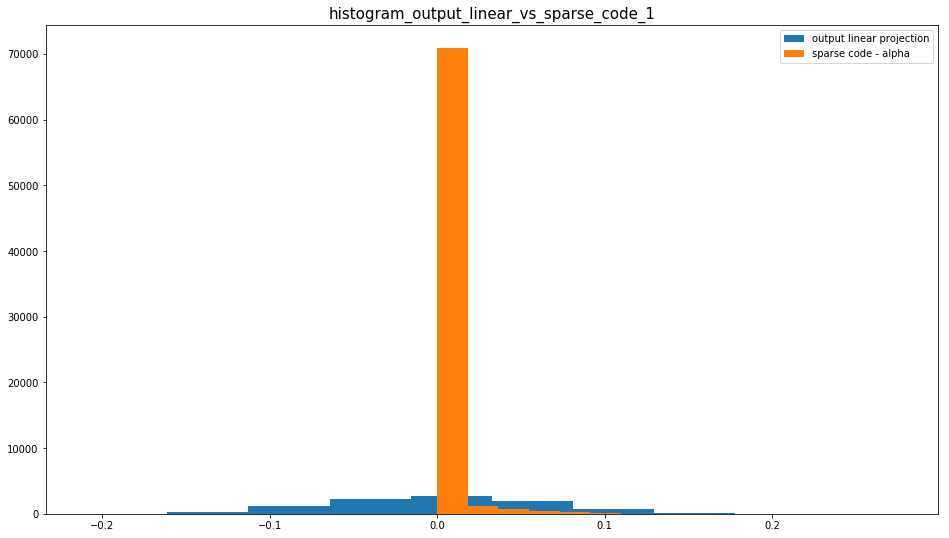

In [62]:
plt.figure()
plt.hist(lin_out[0:1].view(-1).detach().cpu(), label = "output linear projection")
plt.hist(list_x_star[0].view(-1), label = "sparse code - alpha")
plt.legend()
title_plot = "histogram_output_linear_vs_sparse_code_1"
plt.title(title_plot)
plt.savefig(f"plots/{title_plot}.png")
plt.show()

/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:239: FutureWarni

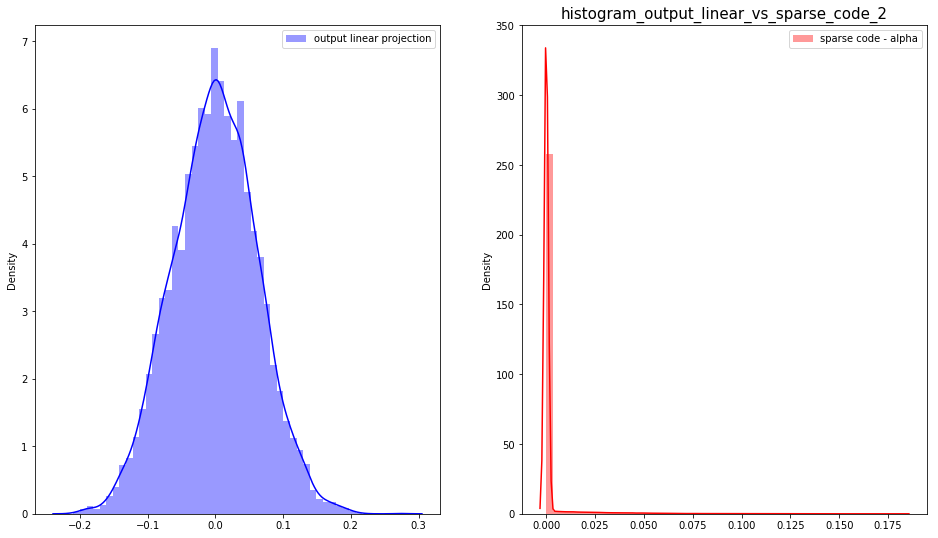

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.distplot(lin_out[0].view(-1).detach().cpu(), label = "output linear projection", ax=ax1, color="b")
sns.distplot(list_x_star[0].view(-1), label = "sparse code - alpha", ax=ax2, color="r")
ax1.legend()
ax2.legend()
title_plot = "histogram_output_linear_vs_sparse_code_2"
plt.title(title_plot)
plt.savefig(f"plots/{title_plot}.png")
plt.show()

In [64]:
print(f" ** Linear projection :\
\n - total number of coefficients : {lin_out[0].detach().cpu().numel()} \
\n - zero count     : {(lin_out[0].detach().cpu().numel() - lin_out[0].detach().cpu().count_nonzero()).item()} \
\n - non zero count : {lin_out[0].detach().cpu().count_nonzero().item()} \
\n - min abs value  : {abs(lin_out[0].detach().cpu()).min()}")

print("-"*50)

print(f" ** Sparse code :\
\n - total number of coefficients : {list_x_star[0].numel()} \
\n - zero count     : {(list_x_star[0].numel() - list_x_star[0].count_nonzero()).item()} \
\n - non zero count : {list_x_star[0].count_nonzero().item()}")

 ** Linear projection :
 - total number of coefficients : 9216 
 - zero count     : 0 
 - non zero count : 9216 
 - min abs value  : 4.991317155145225e-07
--------------------------------------------------
 ** Sparse code :
 - total number of coefficients : 73728 
 - zero count     : 68818 
 - non zero count : 4910


In [65]:
256*6*6, 2048*6*6

(9216, 73728)

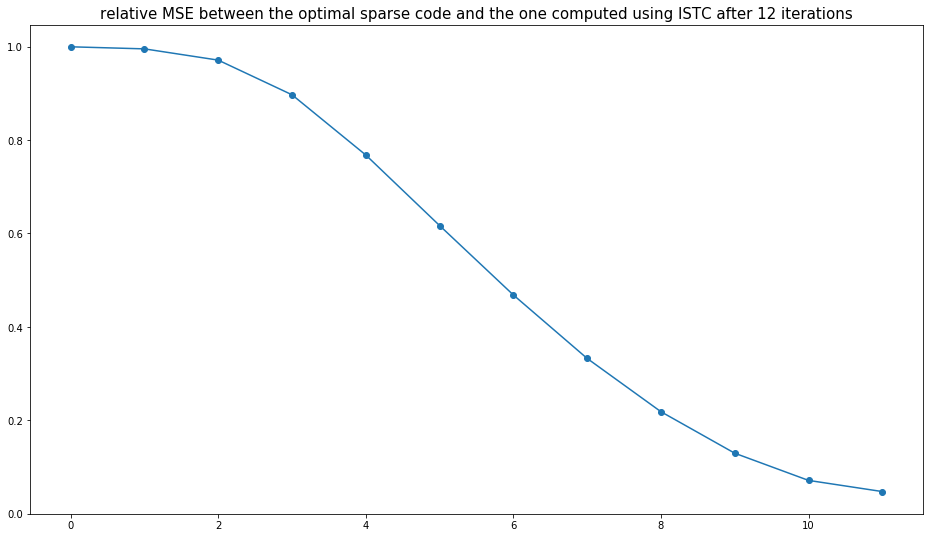

In [66]:
plt.figure()
plt.plot(conv_rel, "-o")
title_plot = f"relative MSE between the optimal sparse code and the one computed using ISTC after {n_iterations} iterations"
plt.title(title_plot)
plt.savefig(f"plots/{title_plot}.png")
plt.show()

In the paper, they reach a value of 0.02 for the relative MSE. We think that the difference is due to the number of classes used (we use 100 and they use all the 1000 classes) and we use just a subset of the validation loader.